In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define the file paths
train_file = 'own/data/1.csv'
validation_test_file = 'own/data/2.csv'

# Function to load and preprocess data
def load_and_preprocess_data(train_file, validation_test_file):
    # Load the training data
    train_df = pd.read_csv(train_file)
    
    # Load the validation and test data
    validation_test_df = pd.read_csv(validation_test_file)
    
    # Convert 'date/time' columns to datetime
    train_df['datetime'] = pd.to_datetime(train_df['date/time'], errors='coerce')
    validation_test_df['datetime'] = pd.to_datetime(validation_test_df['date/time'], errors='coerce')
    
    # Remove the first 1 minute and the last 3 minutes from the training data
    train_start_time = train_df['datetime'].min() + pd.Timedelta(minutes=1)
    train_end_time = train_df['datetime'].max() - pd.Timedelta(minutes=3)
    train_df = train_df[(train_df['datetime'] >= train_start_time) & (train_df['datetime'] <= train_end_time)]
    
    # Remove the first 3 minutes and the last 2.5 minutes from the validation/test data
    validation_start_time = validation_test_df['datetime'].min() + pd.Timedelta(minutes=3)
    validation_end_time = validation_test_df['datetime'].max() - pd.Timedelta(minutes=2.5)
    validation_test_df = validation_test_df[(validation_test_df['datetime'] >= validation_start_time) & (validation_test_df['datetime'] <= validation_end_time)]
    
    # Split validation_test_df into validation and test sets
    mid_index = len(validation_test_df) // 2
    val_df = validation_test_df.iloc[:mid_index]
    test_df = validation_test_df.iloc[mid_index:]
    
    return train_df, val_df, test_df

# Load datasets
train_df, val_df, test_df = load_and_preprocess_data(train_file, validation_test_file)

print('Loading complete')
train_df.head(), val_df.head(), test_df.head()


2024-06-13 23:42:37.697441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 23:42:38.362010: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-13 23:42:38.362082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-

Loading complete


(                       date/time     gyro_x    gyro_y    gyro_z   accel_x  \
 8425  2024-06-05 14:09:12.810708  47.229008  1.580153  4.488550  0.464475   
 8426  2024-06-05 14:09:12.818031  47.030534  0.419847  5.343511 -0.964863   
 8427  2024-06-05 14:09:12.824984  47.328244 -4.145038  6.557252 -0.799663   
 8428  2024-06-05 14:09:12.832316  48.068702 -3.725191  6.763359  1.841141   
 8429  2024-06-05 14:09:12.839155  47.679389 -1.847328  6.595420  3.287239   
 
        accel_y    accel_z          x          y                   timestamp  \
 8425  0.493206   7.393295  25.891441  53.151175  2024-06-05 14:09:12.810708   
 8426  0.105345   7.541735  25.891441  53.151175  2024-06-05 14:09:12.818031   
 8427  0.849942   8.384494  25.891441  53.151175  2024-06-05 14:09:12.824984   
 8428  0.289698  10.572795  25.891441  53.151175  2024-06-05 14:09:12.832316   
 8429  0.694318  11.298238  25.891441  53.151175  2024-06-05 14:09:12.839155   
 
          x_cam     y_cam     z_cam             

In [2]:
# Define features and targets
features = ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z', 'x_cam', 'y_cam', 'z_cam']
targets = ['x', 'y']

# Scale the features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_df[features])
val_X_scaled = scaler.transform(val_df[features])
test_X_scaled = scaler.transform(test_df[features])

# Extract target values
train_y = train_df[targets].values
val_y = val_df[targets].values
test_y = test_df[targets].values

# Convert the data into sequences
def create_sequences(data, truth, sequence_length=400):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(truth[i+sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 400
X_train, y_train = create_sequences(train_X_scaled, train_y, sequence_length)
X_val, y_val = create_sequences(val_X_scaled, val_y, sequence_length)
X_test, y_test = create_sequences(test_X_scaled, test_y, sequence_length)

print('Input sequences complete')


Input sequences complete


In [3]:
# Define the model with fewer layers to reduce overfitting
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, len(features))),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(50, return_sequences=True, kernel_regularizer='l2'),
    BatchNormalization(),
    LSTM(50, kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(50, activation='relu', kernel_regularizer='l2'),
    Dense(len(targets))
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError(name='rmse')])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_rmse = model.evaluate(X_test, y_test)
print(f'Test RMSE: {test_rmse:.4f} meters')

# Export the model
model.save('trajectory_model.h5')

2024-06-13 23:42:41.200160: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: /usr/lib/x86_64-linux-gnu/libcuda.so.1: file too short; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-13 23:42:41.200188: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 398, 32)           896       
                                                                 
 batch_normalization (BatchN  (None, 398, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 199, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 199, 50)           16600     
                                                                 
 batch_normalization_1 (Batc  (None, 199, 50)          2

898/898 [==============================] - 36s 39ms/step


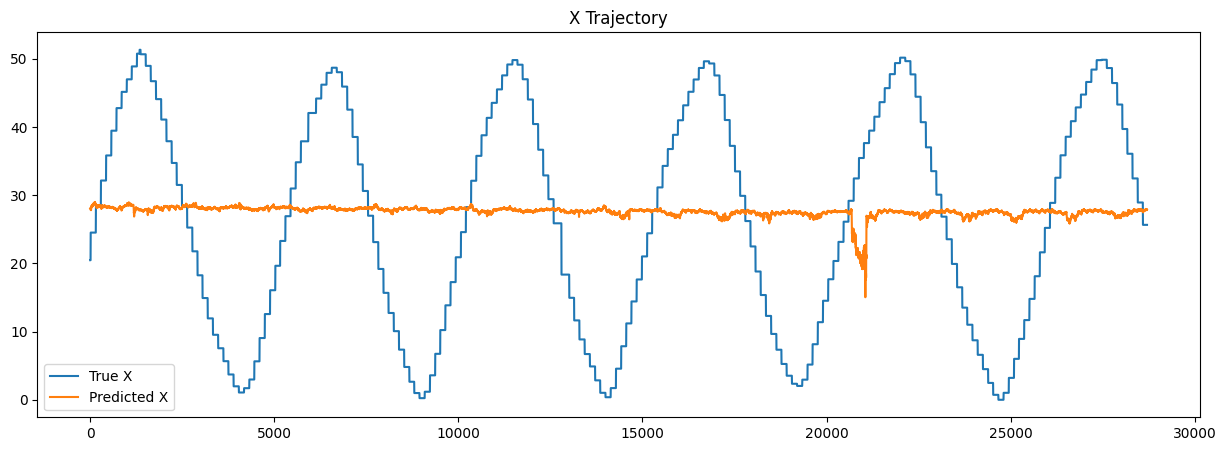

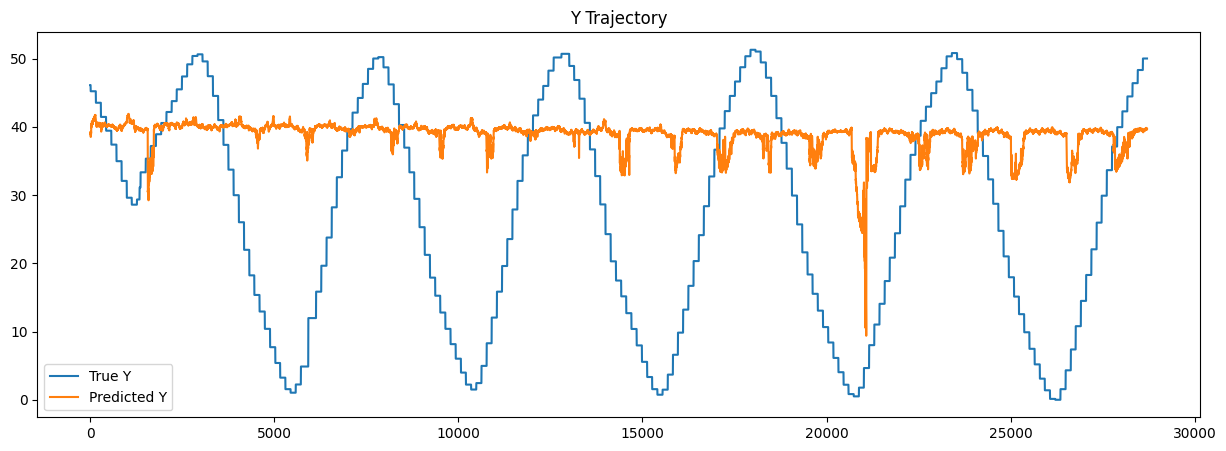

In [4]:
from tensorflow.keras.models import load_model

# Load the model and test it
loaded_model = load_model('trajectory_model.h5')

# Predict using the test data
y_pred = loaded_model.predict(X_test)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
plt.plot(y_pred[:, 0], label='Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
plt.plot(y_pred[:, 1], label='Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()

898/898 [==============================] - 37s 40ms/step
RMSE before filtering: 18.167745592769506
RMSE after filtering: 18.19475564181154


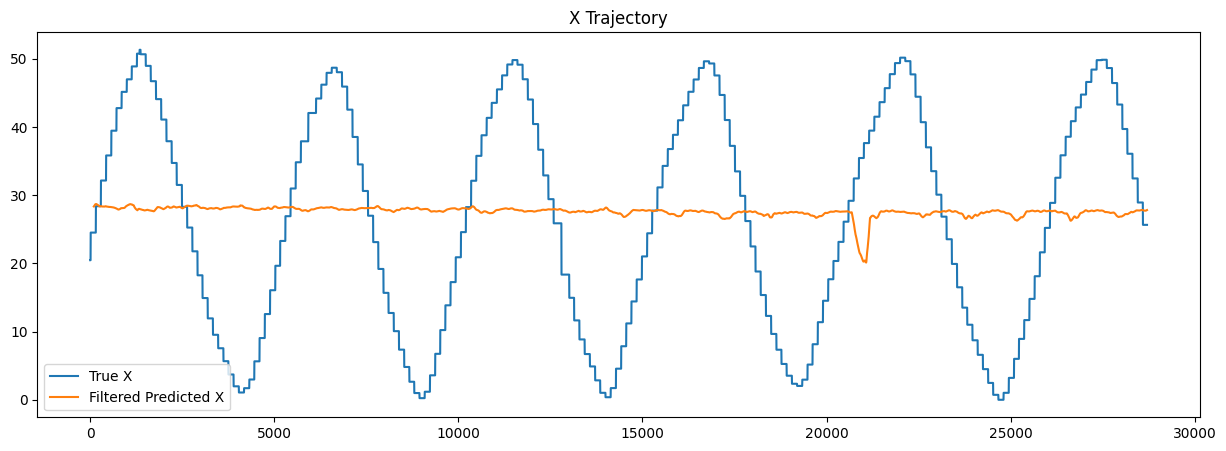

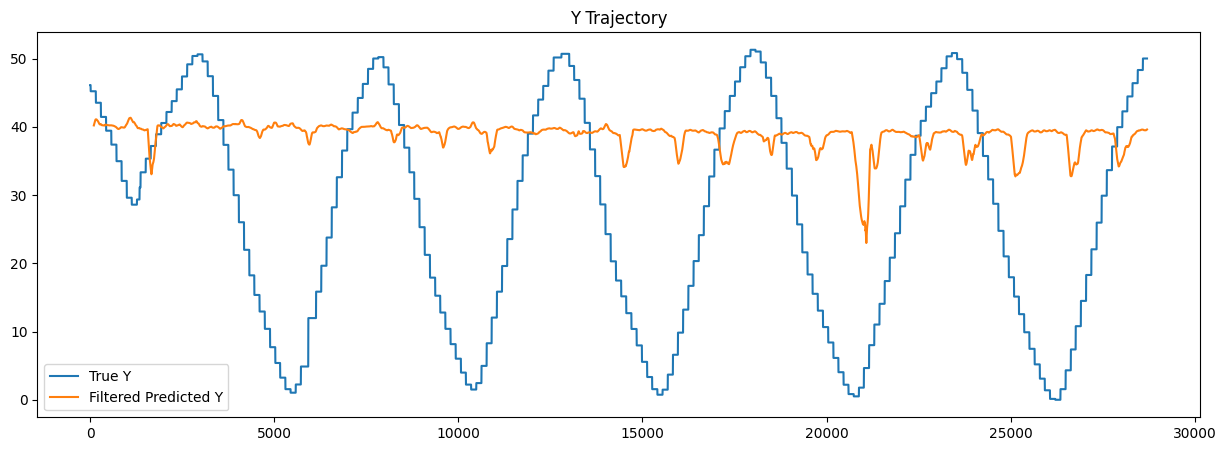

In [5]:
from sklearn.metrics import mean_squared_error
# Load the model and test it
loaded_model = load_model('trajectory_model.h5')

# Predict using the test data
y_pred = loaded_model.predict(X_test)

# Calculate the RMSE
rmse_before_filter = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE before filtering: {rmse_before_filter}')

# Apply a moving average filter to the predicted data
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average filter to each predicted dimension separately
y_pred_filtered = np.array([moving_average(y_pred[:, i]) for i in range(y_pred.shape[1])]).T

# Align the test data to match the length of the filtered predictions
y_test_aligned = y_test[len(y_test) - len(y_pred_filtered):]

# Calculate the RMSE again after filtering
rmse_after_filter = np.sqrt(mean_squared_error(y_test_aligned, y_pred_filtered))
print(f'RMSE after filtering: {rmse_after_filter}')

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 0], label='True X')
#plt.plot(y_pred[:, 0], label='Predicted X')
plt.plot(np.arange(len(y_test) - len(y_pred_filtered), len(y_test)), y_pred_filtered[:, 0], label='Filtered Predicted X')
plt.legend()
plt.title('X Trajectory')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, 1], label='True Y')
#plt.plot(y_pred[:, 1], label='Predicted Y')
plt.plot(np.arange(len(y_test) - len(y_pred_filtered), len(y_test)), y_pred_filtered[:, 1], label='Filtered Predicted Y')
plt.legend()
plt.title('Y Trajectory')
plt.show()